# Compare Experimental Results

In [1]:
% matplotlib inline
import os, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data_dir = 'data/data-recsys16'

In [3]:
suffix = ['Osak', 'Glas', 'Edin', 'Toro', 'Melb']
datnames = ['Osaka', 'Glasgow', 'Edinburgh', 'Toronto', 'Melbourne']

In [4]:
KX = 100  # 100 folds in user specific setting
kxstr = str(KX) + 'X-'
ALPHA = 0.5
alphastr = str(ALPHA).replace('.', '_') + '-'

Load trajectories data.

In [5]:
def load_traj(suffix, dat_ix, noshort):
    assert(0 <= dat_ix <= len(suffix))
    if noshort == True:
        ftraj = os.path.join(data_dir, 'traj-noshort-' + suffix[dat_ix] + '.csv')
    else:
        ftraj = os.path.join(data_dir, 'traj-all-' + suffix[dat_ix] + '.csv')
    traj_all = pd.read_csv(ftraj)
    return traj_all

Compute the F1 score for recommended trajectory.

In [6]:
def calc_F1(seq_act, seq_rec):
    '''Compute recall, precision and F1 when trajectories contain sub-tours'''
    assert(len(seq_act) > 0)
    assert(len(seq_rec) > 0)
    match_tags = np.zeros(len(seq_act), dtype=np.bool)
    for poi in seq_rec:
        for j in range(len(seq_act)):
            if match_tags[j] == False and poi == seq_act[j]:
                match_tags[j] = True
                break
    intersize = np.nonzero(match_tags)[0].shape[0]
    recall = intersize / len(seq_act)
    precision = intersize / len(seq_rec)
    F1 = 2 * precision * recall / (precision + recall)
    return F1

Load results data.

In [7]:
def load_results(suffix, dat_ix, noshort, kxstr, alphastr):
    assert(0 <= dat_ix <= len(suffix))
    
    if noshort == True:
        # user specific results
        frecdict_rank_spec = os.path.join(data_dir, 'rank-noshort-specific-' + kxstr + suffix[dat_ix] + '.pkl')
        frecdict_tran_spec = os.path.join(data_dir, 'tran-noshort-specific-' + kxstr + suffix[dat_ix] + '.pkl')
        frecdict_comb_spec = os.path.join(data_dir, 'comb-noshort-specific-' + alphastr + kxstr + suffix[dat_ix]+'.pkl')

        # user agnostic results
        frecdict_rank_agno = os.path.join(data_dir, 'rank-noshort-agnostic-' + suffix[dat_ix] + '.pkl')
        frecdict_tran_agno = os.path.join(data_dir, 'tran-noshort-agnostic-' + suffix[dat_ix] + '.pkl')
        frecdict_comb_agno = os.path.join(data_dir, 'comb-noshort-agnostic-' + alphastr + suffix[dat_ix] + '.pkl')
    else:
        # user specific results
        frecdict_rank_spec = os.path.join(data_dir, 'rank-all-specific-' + kxstr + suffix[dat_ix] + '.pkl')
        frecdict_tran_spec = os.path.join(data_dir, 'tran-all-specific-' + kxstr + suffix[dat_ix] + '.pkl')
        frecdict_comb_spec = os.path.join(data_dir, 'comb-all-specific-' + alphastr + kxstr + suffix[dat_ix] + '.pkl')

        # user agnostic results
        frecdict_rank_agno = os.path.join(data_dir, 'rank-all-agnostic-' + suffix[dat_ix] + '.pkl')
        frecdict_tran_agno = os.path.join(data_dir, 'tran-all-agnostic-' + suffix[dat_ix] + '.pkl')
        frecdict_comb_agno = os.path.join(data_dir, 'comb-all-agnostic-' + alphastr + suffix[dat_ix] + '.pkl')
    
    # load results data
    recdict_rank_spec = pickle.load(open(frecdict_rank_spec, 'rb'))
    recdict_rank_agno = pickle.load(open(frecdict_rank_agno, 'rb'))
    recdict_tran_spec = pickle.load(open(frecdict_tran_spec, 'rb'))
    recdict_tran_agno = pickle.load(open(frecdict_tran_agno, 'rb'))
    recdict_comb_spec = pickle.load(open(frecdict_comb_spec, 'rb'))
    recdict_comb_agno = pickle.load(open(frecdict_comb_agno, 'rb'))

    res = [recdict_rank_spec, recdict_rank_agno, \
           recdict_tran_spec, recdict_tran_agno, \
           recdict_comb_spec, recdict_comb_agno]
    return res

In [8]:
def compare_results(suffix, dat_ix, noshort, kxstr, alphastr):
    traj_all = load_traj(suffix, dat_ix, noshort)
    results = load_results(suffix, dat_ix, noshort, kxstr, alphastr)
    recdict_rank_spec = results[0]
    recdict_rank_agno = results[1]
    recdict_tran_spec = results[2]
    recdict_tran_agno = results[3]
    recdict_comb_spec = results[4]
    recdict_comb_agno = results[5]
    
    # Popularity based ranking
    rank_pop_agno = dict()
    rank_pop_spec = dict()
    
    # Feature based ranking
    rank_f_agno = dict()
    rank_f_spec = dict()
    
    # POI transition with DP
    tran_dp_agno = dict()
    tran_dp_spec = dict()
    
    # POI transition with ILP
    tran_ilp_agno = dict()
    tran_ilp_spec = dict()
    
    # Feature based ranking + POI transition with DP
    comb_dp_agno = dict()
    comb_dp_spec = dict()
    
    # Feature based ranking + POI transition with ILP
    comb_ilp_agno = dict()
    comb_ilp_spec = dict()
    
    for user in sorted(traj_all['userID'].unique().tolist()):
        trajids = traj_all[traj_all['userID'] == user]['trajID'].unique().tolist()
        key = len(trajids)
        if key not in rank_pop_agno: rank_pop_agno[key] = []
        if key not in rank_pop_spec: rank_pop_spec[key] = []
        if key not in rank_f_agno:   rank_f_agno[key]   = []
        if key not in rank_f_spec:   rank_f_spec[key]   = []
            
        if key not in tran_dp_agno:  tran_dp_agno[key]  = []
        if key not in tran_dp_spec:  tran_dp_spec[key]  = []
        if key not in tran_ilp_agno: tran_ilp_agno[key] = []
        if key not in tran_ilp_spec: tran_ilp_spec[key] = []
            
        if key not in comb_dp_agno:  comb_dp_agno[key]  = []
        if key not in comb_dp_spec:  comb_dp_spec[key]  = []
        if key not in comb_ilp_agno: comb_ilp_agno[key] = []
        if key not in comb_ilp_spec: comb_ilp_spec[key] = []

        for tid in trajids:
            if tid not in recdict_rank_agno: continue
            rank_pop_agno[key].append(calc_F1(recdict_rank_agno[tid]['REAL'], recdict_rank_agno[tid]['REC_POP']))
            rank_pop_spec[key].append(calc_F1(recdict_rank_spec[tid]['REAL'], recdict_rank_spec[tid]['REC_POP']))
            rank_f_agno[key].append(calc_F1(recdict_rank_agno[tid]['REAL'], recdict_rank_agno[tid]['REC_FEATURE']))
            rank_f_spec[key].append(calc_F1(recdict_rank_spec[tid]['REAL'], recdict_rank_spec[tid]['REC_FEATURE']))
            
            tran_dp_agno[key].append(calc_F1(recdict_tran_agno[tid]['REAL'], recdict_tran_agno[tid]['REC_DP']))
            tran_dp_spec[key].append(calc_F1(recdict_tran_spec[tid]['REAL'], recdict_tran_spec[tid]['REC_DP']))
            tran_ilp_agno[key].append(calc_F1(recdict_tran_agno[tid]['REAL'], recdict_tran_agno[tid]['REC_ILP']))
            tran_ilp_spec[key].append(calc_F1(recdict_tran_spec[tid]['REAL'], recdict_tran_spec[tid]['REC_ILP']))
            
            comb_dp_agno[key].append(calc_F1(recdict_comb_agno[tid]['REAL'], recdict_comb_agno[tid]['REC_DP']))
            comb_dp_spec[key].append(calc_F1(recdict_comb_spec[tid]['REAL'], recdict_comb_spec[tid]['REC_DP']))
            comb_ilp_agno[key].append(calc_F1(recdict_comb_agno[tid]['REAL'], recdict_comb_agno[tid]['REC_ILP']))
            comb_ilp_spec[key].append(calc_F1(recdict_comb_spec[tid]['REAL'], recdict_comb_spec[tid]['REC_ILP']))
        
        if len(rank_pop_agno[key]) == 0: 
            del rank_pop_agno[key]; del rank_pop_spec[key]; del rank_f_agno[key]; del rank_f_spec[key]
            del tran_dp_agno[key]; del tran_dp_spec[key]; del tran_ilp_agno[key]; del tran_ilp_spec[key]
            del comb_dp_agno[key]; del comb_dp_spec[key]; del comb_ilp_agno[key]; del comb_ilp_spec[key]
    
    res = [rank_pop_agno, rank_pop_spec, rank_f_agno,   rank_f_spec,   \
           tran_dp_agno,  tran_dp_spec,  tran_ilp_agno, tran_ilp_spec, \
           comb_dp_agno,  comb_dp_spec,  comb_ilp_agno, comb_ilp_spec]
    return res

Plot results.

In [9]:
dat_ix = 3

In [10]:
noshort = True

In [11]:
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

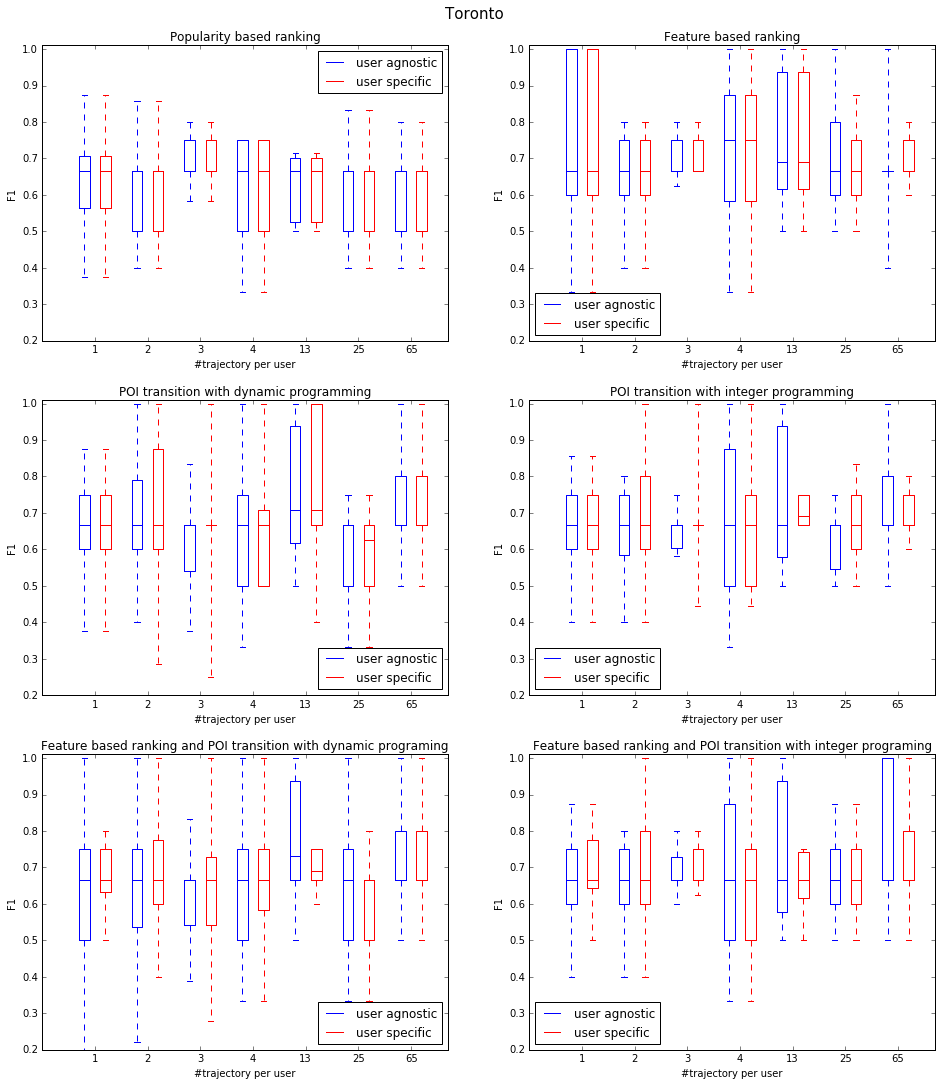

In [12]:
results = compare_results(suffix, dat_ix, noshort, kxstr, alphastr)
methods = ['Popularity based ranking', 'Feature based ranking', \
           'POI transition with dynamic programming', 'POI transition with integer programming', \
           'Feature based ranking and POI transition with dynamic programing', \
           'Feature based ranking and POI transition with integer programing']

plt.figure(figsize=[16, 18])
plt.suptitle(datnames[dat_ix], x=0.5, y=0.93, fontsize=15)
agno_str = 'user agnostic'
spec_str = 'user specific'
c1 = 'blue'
c2 = 'red'

for j in range(len(methods)):
    plt.subplot(3, 2, j+1); plt.title(methods[j])
    X = sorted(results[2*j].keys())
    Y1 = [results[2*j][x] for x in X]   # user agnostic results
    Y2 = [results[2*j+1][x] for x in X] # user specific results
    assert(len(X) == len(Y1) == len(Y2))
    
    bpl = plt.boxplot(Y1, positions=np.arange(1, len(Y1)+1)-0.2, sym='', widths=0.2)
    bpr = plt.boxplot(Y2, positions=np.arange(1, len(Y1)+1)+0.2, sym='', widths=0.2)
    set_box_color(bpl, c1)
    set_box_color(bpr, c2)
    
    plt.xticks(np.arange(1, len(Y1)+1), X)
    plt.xlim(xmin=0)
    plt.ylim([0.2, 1.01])
    plt.xlabel('#trajectory per user')
    plt.ylabel('F1')
    
    plt.plot([], c=c1, label=agno_str)
    plt.plot([], c=c2, label=spec_str)
    plt.legend(loc='best')